In [13]:
from google.colab import drive
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [2]:
# connect to colab, or you can use local path
drive.mount('/content/drive/')
folder_path = '/content/drive/MyDrive/IT5006/GW/'
#load data

# 循环读取10到20年的11个文件，放进一个df里（一开始我以为是我数据量太小所以最后结果不咋滴，后面发现整了11个文件进去，精度也没什么提升
'''
df = pd.DataFrame()
for year in range(10, 21):
    filename = f"MERGED20{year}_{year+1}_PP.csv"
    # 读取CSV文件并加入到merged_df中
    temp_df = pd.read_csv(folder_path+filename)
    df = pd.concat([df, temp_df], ignore_index=True)
'''
#如果测试只用一条数据的话，直接用下面这个，上面的无视掉
df = pd.read_csv(folder_path+'MERGED2018_19_PP.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<ipython-input-2-e487937292e8>:16: DtypeWarning: Columns (1729,1909,1910,1911,1912,1913,2376,2377,2958) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(folder_path+'MERGED2018_19_PP.csv')


In [111]:
# 我数据量取到这个份上也没有变很好
df.shape

(80911, 2989)

In [3]:
# 这里主要是构建数据集，把我们要用的X,y属性先拿出来
Dataset = df[['PCTPELL','PCTFLOAN','GRAD_DEBT_MDN','WDRAW_DEBT_MDN','CONTROL','UGDS','ADM_RATE','SAT_AVG','COMP_ORIG_YR4_RT','LO_INC_COMP_ORIG_YR4_RT','PELL_COMP_ORIG_YR4_RT','LOAN_COMP_ORIG_YR4_RT','OVERALL_YR4_N','PELL_YR4_N','LOAN_YR4_N']]
# CONTROL是categorical变量，要转成numerical的，不然没办法回归
one_hot = pd.get_dummies(Dataset['CONTROL'], prefix='CONTROL')
Dataset = pd.concat([Dataset, one_hot], axis=1)
Dataset.drop('CONTROL', axis=1)
Dataset

,PCTPELL,PCTFLOAN,GRAD_DEBT_MDN,WDRAW_DEBT_MDN,CONTROL,UGDS,ADM_RATE,SAT_AVG,COMP_ORIG_YR4_RT,LO_INC_COMP_ORIG_YR4_RT,PELL_COMP_ORIG_YR4_RT,LOAN_COMP_ORIG_YR4_RT,OVERALL_YR4_N,PELL_YR4_N,LOAN_YR4_N,CONTROL_1,CONTROL_2,CONTROL_3
0,0.7067,0.7503,33375,10250,1,4990.0,0.8986,957.0,0.210526315789,0.172811059908,0.196666666667,0.20796812749,1368,1200,1255,1,0,0
1,0.3632,0.5127,22500,9500,1,13186.0,0.9211,1220.0,0.461707585196,0.423139158576,0.448044692737,0.464022894522,2729,1790,2446,1,0,0
2,0.7673,0.8962,27334,9500,2,351.0,NaN,NaN,0.162962962963,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,135,PrivacySuppressed,PrivacySuppressed,0,1,0
3,0.2698,0.4192,21607,9000,1,7458.0,0.8087,1314.0,0.464680851064,0.471933471933,0.482384823848,0.440579710145,1175,738,1035,1,0,0
4,0.7448,0.7845,32000,11161,1,3903.0,0.9774,972.0,0.237909516381,0.186602870813,0.231239092496,0.22735042735,1282,1146,1170,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,NaN,NaN,9371,4940,1,NaN,NaN,NaN,0.17,0.146187277756,0.17000298775,0.179143389199,3900,3347,2685,1,0,0
6803,NaN,NaN,9371,4940,1,NaN,NaN,NaN,0.17,0.146187277756,0.17000298775,0.179143389199,3900,3347,2685,1,0,0
6804,NaN,NaN,12125,4750,3,NaN,NaN,NaN,0.448979591837,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,49,PrivacySuppressed,39,0,0,1
6805,NaN,NaN,21000,12000,3,NaN,NaN,NaN,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,0,0,1


In [9]:
# 这里是我用到的模型，一共用了三个模型，XGBoost，LightGBM和线性回归(后面又加了随机森林和SVM)，SVM巨慢😅我设了最大迭代次数，不然跑不出来😅

def RMSEXGBR(n_estimators, max_depth, learning_rate, X_train, y_train, X_test, y_test):
  # XGBoost回归模型训练
  model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  RMSE = mean_squared_error(y_test, y_pred, squared=False)
  feature_importances = model.feature_importances_
  return y_pred, RMSE, feature_importances

def RMSELGBMR(n_estimators, max_depth, learning_rate, X_train, y_train, X_test, y_test):
  # LightGbm回归模型训练
  model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  RMSE = mean_squared_error(y_test, y_pred, squared=False)
  feature_importances = model.feature_importances_
  return y_pred, RMSE, feature_importances

def RMSELR(X_train, y_trian, X_test, y_test):
  # 线性回归模型训练
  model = LinearRegression()
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  RMSE = mean_squared_error(y_test, y_pred, squared=False)
  feature_importances = model.coef_
  return y_pred, RMSE, feature_importances

def RMSESVM(X_train, y_trian, X_test, y_test):
  # SVM回归模型训练
  model = SVR(kernel='linear', C=100, gamma=0.1, epsilon=.1, max_iter=100000)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  RMSE = mean_squared_error(y_test, y_pred, squared=False)
  feature_importances = model.coef_
  return y_pred, RMSE, feature_importances

def RMSERndF(n_estimators, X_train, y_trian, X_test, y_test):
  # 随机森林回归模型训练
  model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  RMSE = mean_squared_error(y_test, y_pred, squared=False)
  feature_importances = model.feature_importances_
  return y_pred, RMSE, feature_importances


In [38]:
# 这个函数用来把一些PrivacySuppressed给清洗掉
def Process_Dataset(X_col, y_col):
  DS1 = Dataset[X_col+[y_col]].dropna()
  for ix_col in X_col+[y_col]:
    DS1[ix_col] = pd.to_numeric(DS1[ix_col], errors='coerce') # 将cd列转换为数值类型，遇到非数字的值转换为NaN
    DS1 = DS1[DS1[ix_col].notna()]
  
  #X 进normalization，把数据缩放到0-1这个区间
  scaler = MinMaxScaler()
  X = pd.DataFrame(scaler.fit_transform(DS1[X_col]), columns = X_col)
  Y = DS1[y_col]
  return X, Y

# test 1, X use PCTPELL	PCTFLOAN GRAD_DEBT_MDN
# necessary X
#X_col = ['PCTPELL','PCTFLOAN','GRAD_DEBT_MDN','WDRAW_DEBT_MDN']
#X_ctr = ['UGDS','ADM_RATE','SAT_AVG','CONTROL_1','CONTROL_2','CONTROL_3']

# X这里对哪些该兴趣手动改就行，其他部分程序都不用改
#X_col = ['PCTPELL','PCTFLOAN','GRAD_DEBT_MDN','WDRAW_DEBT_MDN','UGDS','SAT_AVG','ADM_RATE','CONTROL_1','CONTROL_2','CONTROL_3']
#y_cols = ['COMP_ORIG_YR4_RT','LO_INC_COMP_ORIG_YR4_RT','PELL_COMP_ORIG_YR4_RT','LOAN_COMP_ORIG_YR4_RT','OVERALL_YR4_N','PELL_YR4_N','LOAN_YR4_N']
X_col = ['PCTPELL','PCTFLOAN','GRAD_DEBT_MDN','WDRAW_DEBT_MDN']#,'UGDS']#,'CONTROL_1','CONTROL_2','CONTROL_3']
y_cols = ['COMP_ORIG_YR4_RT','LO_INC_COMP_ORIG_YR4_RT']
# 我把每个Y都试了一遍，看哪个效果最好（最后发现都差求不多其实）


# 下面这些变量用来存储找到效果最好的模型后所需要保留的信息
minRMSE = 1 # 最小RMSE
min_X_col = [] #效果最好的X选取的属性（然而其实是手动调的，本来想做成循环的，但是是排列组合，效率不是很高）
min_y_col = '' #用哪个y效果最好
model = '' #选用哪个模型
best_y_pred = [] #y的预测值列表
best_weight ='' #最好的模型中，各项的权值
for y_col in y_cols:
  X,Y = Process_Dataset(X_col, y_col)
  
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
  
  y_pred, tRMSE, feature_importances = RMSEXGBR(80,4,0.1,X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
  if tRMSE < minRMSE:
    minRMSE = tRMSE
    min_X_col = X_col
    min_y_col = y_col
    model = 'XGBoost Regressor'
    best_y_pred = y_pred
    best_y_test = y_test
    best_weight = feature_importances
  
  y_pred, tRMSE, feature_importances = RMSELGBMR(80,4,0.1,X_train, y_train, X_test, y_test)
  if tRMSE < minRMSE:
    minRMSE = tRMSE
    min_X_col = X_col
    min_y_col = y_col
    model = 'lightGBM Regressor'
    best_y_pred = y_pred
    best_y_test = y_test
    best_weight = feature_importances
  
  y_pred, tRMSE, feature_importances = RMSELR(X_train, y_train, X_test, y_test)
  if tRMSE < minRMSE:
    minRMSE = tRMSE
    min_X_col = X_col
    min_y_col = y_col
    model = 'Linear Regressor'
    best_y_pred = y_pred
    best_y_test = y_test
    best_weight = feature_importances

  y_pred, tRMSE, feature_importances= RMSESVM(X_train, y_train, X_test, y_test)
  if tRMSE < minRMSE:
    minRMSE = tRMSE
    min_X_col = X_col
    min_y_col = y_col
    model = 'SVM Regressor'
    best_y_pred = y_pred
    best_y_test = y_test
    best_weight = feature_importances

  y_pred, tRMSE, feature_importances = RMSERndF(80, X_train, y_train, X_test, y_test)
  if tRMSE < minRMSE:
    minRMSE = tRMSE
    min_X_col = X_col
    min_y_col = y_col
    model = 'Random Forrest Regressor'
    best_y_pred = y_pred
    best_y_test = y_test
    best_weight = feature_importances

print(f'The best model is :{model}.')
print(f'X col = {min_X_col}.')
print(f'y col = {min_y_col}.')
print(f'RMSE = {minRMSE}.')

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The best model is :Random Forrest Regressor.
X col = ['PCTPELL', 'PCTFLOAN', 'GRAD_DEBT_MDN', 'WDRAW_DEBT_MDN'].
y col = COMP_ORIG_YR4_RT.
RMSE = 0.13050629830562263.


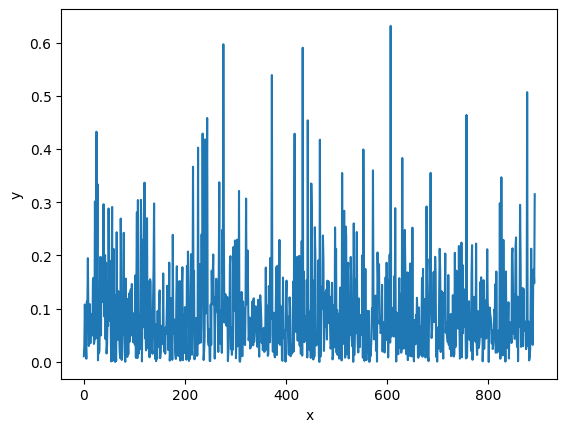

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

data = {'y_test': best_y_test, 'y_pred': best_y_pred}
df_plot = pd.DataFrame(data).reset_index(drop=True)
df_plot['y_delta'] = abs(df_plot['y_test'] - df_plot['y_pred'])
sns.lineplot(data=df_plot['y_delta'])
plt.xlabel("x")
plt.ylabel("y")
#plt.xticks(df_plot.index, rotation=90)
plt.show()


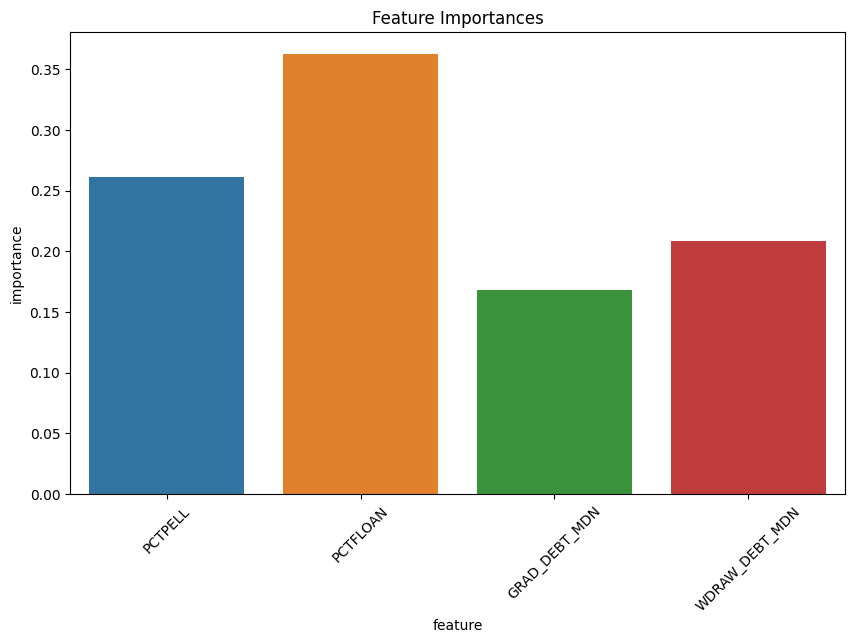

In [40]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 将feature_importances存储为一个dataframe
feature_importances = pd.DataFrame({'feature': X_col, 'importance': best_weight})

# 画权值的柱状图
plt.figure(figsize=(10, 6))
sns.barplot(x='feature', y='importance', data=feature_importances)
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()

In [25]:
X_train

,PCTPELL,PCTFLOAN,GRAD_DEBT_MDN,WDRAW_DEBT_MDN,UGDS,SAT_AVG,ADM_RATE,CONTROL_1,CONTROL_2,CONTROL_3
861,0.415904,0.677025,0.651905,0.402401,0.009263,0.334187,0.851945,1.0,0.0,0.0
260,0.661168,0.644959,0.190581,0.130765,0.004717,0.170294,0.678064,0.0,1.0,0.0
594,0.373631,0.572782,0.623227,0.646873,0.019006,0.338028,0.804789,0.0,1.0,0.0
184,0.135842,0.467548,0.551130,0.307329,0.098460,0.540333,0.767670,1.0,0.0,0.0
643,0.578554,0.690358,0.356439,0.130765,0.036656,0.243278,0.760456,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1044,0.294497,0.778072,0.669582,0.130765,0.029778,0.380282,0.645337,0.0,1.0,0.0
1095,0.247841,0.351185,0.569733,0.280165,0.028938,0.304738,0.941343,1.0,0.0,0.0
1130,0.955278,0.105124,0.020613,0.076438,0.050636,0.258643,0.731911,1.0,0.0,0.0
860,0.440521,0.729807,0.651905,0.402401,0.009314,0.361076,0.795588,1.0,0.0,0.0


In [102]:
######################################################## 下面调参部分先不管， 上面模型效果感觉一般 ########################################################

(1286,)

In [ ]:
########################################################参数调整########################################################
import xgboost as xgb  
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error


# Define parameter grid for grid search
param_grid = {
    'n_estimators': range(20, 200, 20),
    'max_depth': [3,4,5],
    'learning_rate':[0.003, 0.005, 0.007, 0.1,0.2 ,0.3]
}

# Perform grid search with 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid, cv=kf, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print('Report the best parameters and rmse for best result:')
print('##############################################################################################')
print('Grid Search Best Parameters: ', grid_search.best_params_)
#print('Grid Search Best RMSE: ', -grid_search.best_score_)

best_grid_model = grid_search.best_estimator_

y_pred = best_grid_model.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred, squared=False)

print('RMSE:', RMSE)

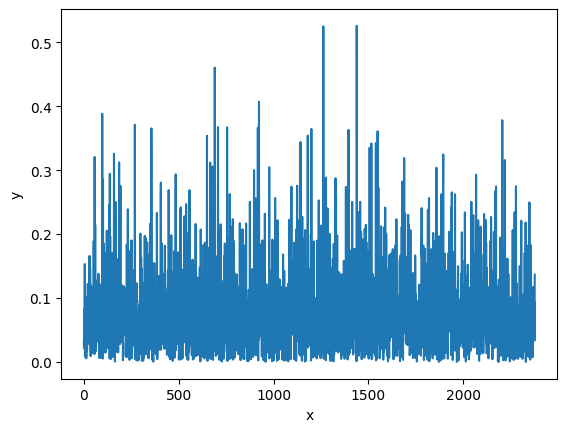

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

data = {'y_test': y_test, 'y_pred': y_pred}
df_plot = pd.DataFrame(data).reset_index(drop=True)
df_plot['y_delta'] = abs(df_plot['y_test'] - df_plot['y_pred'])
sns.lineplot(data=df_plot['y_delta'])
plt.xlabel("x")
plt.ylabel("y")
#plt.xticks(df_plot.index, rotation=90)
plt.show()


In [ ]:
########################################################参数调整########################################################
from lightgbm import LGBMRegressor
param_grid = {
    'n_estimators': range(20,100,10),
    'max_depth': range(3,5),
    'learning_rate':[0.003, 0.005, 0.007, 0.1,0.2 ,0.3]
}

# Perform grid search with 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=False)
grid_search_LGBM = GridSearchCV(LGBMRegressor(random_state=42), param_grid, cv=kf, scoring='neg_root_mean_squared_error')
grid_search_LGBM.fit(X_train, y_train)


print('Report the best parameters and rmse for best result:')
print('##############################################################################################')
print('Grid Search Best Parameters: ', grid_search_LGBM.best_params_)
#print('Grid Search Best RMSE: ', grid_search_LGBM.best_score_)
print('##############################################################################################')

best_grid_model_LGBM = grid_search.best_estimator_

y_pred = best_grid_model_LGBM.predict(X_test)

# Calculate the RMSE for each model
RMSE_score = mean_squared_error(y_test, y_pred)

print("Predicted RMSE score:", RMSE_score)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

data = {'y_test': y_test, 'y_pred': y_pred}
df_plot = pd.DataFrame(data).reset_index(drop=True)
df_plot['y_delta'] = abs(df_plot['y_test'] - df_plot['y_pred'])
sns.lineplot(data=df_plot['y_delta'])
plt.xlabel("x")
plt.ylabel("y")
#plt.xticks(df_plot.index, rotation=90)
plt.show()
